In [1]:
from mpi4py import MPI
import coqui

# Create CoQui MPI handler and set logging verbosity in the beginning 
coqui_mpi = coqui.MpiHandler()
coqui.set_verbosity(coqui_mpi, output_level=1)

--------------------------------------------------------------------------
Ignoring value for oob_tcp_if_exclude on ccqlin065 (10.250.112.0/20: Did not find interface matching this subnet).
(You can safely ignore this message.)
--------------------------------------------------------------------------


# GW Electronic Structure with CoQuí

This notebook demonstrates CoQuí’s capabilities for performing GW many-body perturbation theory calculations for silicon, following the three phases of a typical CoQuí workflow shown below. This GW workflow also serves as a representative example of the overall structure of a many-body calculation in CoQuí. The resulting script is intended as a **reusable template** for other electronic-structure solvers available in CoQuí.

**What you’ll learn:**
1. How to **build a many-body Hamiltonian** for electronic structure solver in CoQuí (applicable beyond GW)
2. The key parameters controlling a GW calculation in CoQuí
3. How to **visualize GW band structures** and **compare** them with DFT results

**Pre-generated data:**
- `data/qe_inputs/si/222/out` → Quantum ESPRESSO PBE results for silicon with 2x2x2 k-mesh
- `data/qe_inputs/si/222/mlwf_dp/nio.mlwf.h5` → MLWFs for the Si $sp^3$ orbitals

> 💡 **Silicon in a nutshell**  
> Silicon crystallizes in the diamond structure and is a prototypical *weakly correlated* semiconductor with covalent $sp^3$ bonding and an indirect band gap between the valence-band maximum at $\Gamma$ and the conduction-band minimum near $X$. Semilocal DFT systematically underestimates this gap, while GW yields quasiparticle energies in much better agreement with experiment, making Si a standard benchmark for many-body perturbation theories.

> ⚠️ **Important note:**  
> The numerical parameters in this notebook (e.g. number of k-points, bands) are set to **unrealistically small values** in order to keep the tutorial interactive and fast to run.  
>  
> For actual GW simulations, the convergence of these parameters must be carefully checked to obtain **physically reliable results**. Here we focus on the workflow and analysis, not on reaching production-level accuracy.

## 🔹 GW Workflow at a glance

<figure style="text-align: center;">
  <img src="./images/coqui_workflow_gw.png" alt="GW workflow in CoQuí" width="60%">
  <figcaption>GW workflow in CoQuí.</figcaption>
</figure>

At a high level, the GW workflow in CoQuí proceeds as follows:

1. **Problem Setup**
   - Build a mean-field object (`coqui.Mf`) containing the single-particle information (structure, k-mesh, bands, orbitals) (see [the previous notebook](01_dft_to_coqui_converter.ipynb)).
   - Construct the **Coulomb Hamiltonian** in a **compressed** format (THC or Cholesky) to reduce the cost of later many-body calculations while maintaining accuracy.
2. **Simulation**
   - Call the desired electronic structure solver (GW in this case) to solve your many-electron problem. 
3. **Post-Processing**:
   - Interpolate the simulation results from a coarse to fine k-mesh, e.g. spectral or band structure interpolation.  
   - Analytically continue imaginary-axis quantities to for physical quantities such as band structures and local density of states.

### Example: GW for silicon
Translating these phases into code yields the following example Python script for the GW calculation of silicon:
```python
from mpi4py import MPI
import coqui

# Create CoQui MPI handler and set logging verbosity 
coqui_mpi = coqui.MpiHandler()
coqui.set_verbosity(coqui_mpi, output_level=1)

# --- Phase 1: Problem setup ---
# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "si", 
    "outdir": "data/qe_inputs/si/222/out", 
    "nbnd": 20
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# Construct Coulomb Hamiltonian (in a compressed THC format)
thc_params = {
    "ecut": 35,
    "thresh": 1e-3
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)

# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "beta": 500,
    "wmax": 1.8,
    "iaft_prec": "medium",
    "niter": 1,
}
coqui.run_gw(params=gw_params, h_int=thc)

# --- Phase 3: Post-processing ---
# (plots / analysis shown later in the notebook)
```
Set the API details aside for now and focus on how the **code structure mirrors the workflow figure**, with a clear separation between phases. We will now break down this example and walk through each phase step by step.

> 💡**Note**: The code structure in this example is not specific to GW; it is common to all electronic structure methods in CoQuí. In particular, the *problem setup* phase is shared across methods, while only the function calls in Phase 2 and 3 need to be changed to match the chosen method. 

### 🔹 Phase 1: Problem Setup — what's happening?

<figure style="text-align: center;">
  <img src="./images/coqui_problem_setup.png" alt="Phase 1 of the many-body calculation workflow in CoQuí" width="60%">
  <figcaption>Phase 1 of the many-body calculation workflow in CoQuí. </figcaption>
</figure>

```python
from mpi4py import MPI
import coqui

# Create CoQui MPI handler and set logging verbosity 
coqui_mpi = coqui.MpiHandler()
coqui.set_verbosity(coqui_mpi, output_level=1)

# --- Phase 1: Problem setup ---
# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "si", 
    "outdir": "data/qe_inputs/si/222/out", 
    "nbnd": 20
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# Construct Coulomb Hamiltonian (in a compressed THC format)
thc_params = {
    "ecut": 35,
    "thresh": 1e-3
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)
```

In this Python snippet, a new function `coqui.make_thc_coulomb` is introduced to build the Coulomb Hamiltonian, which defines the interaction part of the many-electron problem. 

#### ❓ **What happens within `coqui.make_thc_coulomb`?**
Starting from the single-particle basis $\phi^{\textbf{k}}_i(\textbf{r})$ defined in the `Mf` class (see the [previous notebook](01_dft_to_coqui_converter.ipynb) for a recap), `coqui.make_thc_coulomb` evaluates the corresponding matrix elements of the **bare** Coulomb operator $V(\textbf{r}) = 1/|\textbf{r}|$ in the tensor hypercontraction (THC) representation: 
$$
V^{\textbf{k}_1\textbf{k}_2\textbf{k}_3\textbf{k}_4} _{ijkl} = \int d\textbf{r} \int d\textbf{r}' \phi^{\textbf{k}_1*}_{i} (\textbf{r})\phi^{\textbf{k}_2}_{j}(\textbf{r})\frac{1}{|\textbf{r}-\textbf{r}'|}\phi^{\textbf{k}_3*}_{k}(\textbf{r}')\phi^{\textbf{k}_4}_{l}(\textbf{r}') \approx \sum^{N_{\mu}}_{\mu\nu}
X^{\textbf{k}_1*} _{\mu i} X^{\textbf{k}_2} _{\mu j}V^{\textbf{q}} _{\mu\nu} 
X^{\textbf{k}_3*} _{\nu k}X^{\textbf{k}_4} _{\nu l}
$$
This is the most general form of Coulomb Hamiltonian, capturing both **local** and **non-local** interactions among **all** electronic degrees of freedom. Here, the momentum transferred between the product basis $\phi^{\textbf{k}_{1}*}_{i}(\textbf{r})\phi^{\textbf{k}_{2}}_{j}(\textbf{r})$
obeys momentum conservation: $\textbf{k}_1 - \textbf{k}_2 + \textbf{G} = \textbf{k}_3 - \textbf{k}_4 + \textbf{G}' = \textbf{q}$ where $\textbf{G}$, $\textbf{G}'$ are reciprocal lattice vectors of the system. 

> 💡**Note**: The key advantage of CoQuí is its efficient algorithm for constructing the THC form of the bare Coulomb Hamiltonian. The accuracy is systematically controlled by $N_{\mu}$, the number of interpolating points. 

The function signature reads: 
```python
coqui.make_thc_coulomb(mf: coqui.Mf, thc_params: dict) -> coqui.ThcCoulomb. 
```
and it returens a `ThcCoulomb` class encapsulating the bare Coulomb matrix elements in the THC form. 

**Accuracy-relevant parameters:**
- `thc_params["ecut"]` — plane‑wave cutoff (in Hartree unit) for building the Coulomb Hamiltonian. 
- `thc_params["thresh"]` — THC accuracy threshold that controls $N_{\mu}$ (smaller → larer $N_{\mu}$ → higher accuracy, but more expensive).

> 💡**Note**: The MPI configuration is implicitly passed to `make_thc_coulomb` through the `mf` argument. This guarantees a consistent MPI setup between `Mf` and `ThcCoulomb`.

> 💡**Tip**: The resulting `ThcCoulomb` object is universal: the same THC Hamiltonian can be reused across HF, GW, downfolding, and other solvers without modification. 

### ▶️ Hands-on 1: Build Your First *Ab Initio* THC Coulomb Hamiltonian 

Execute the Python snippet below to build a THC Coulomb Hamiltonian for Silicon, and obeserv the output log:
```python
# --- Phase 1: Problem setup ---
# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "si", 
    "outdir": "data/qe_inputs/si/222/out", 
    "nbnd": 20
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# Construct Coulomb Hamiltonian (in a compressed THC format)
thc_params = {
    "ecut": 35,
    "thresh": 1e-3
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)
```

Observe the log output for answer the following questions: 
- What FFT mesh / number of plane waves were used at `ecut=35`?
- How many **interpolating points ($N_{\mu}$** do you see?
- What compression factor (approx.) do you infer as the ratio of memory required for the full $V$ versus its THC form $V_{\mathrm{THC}}$. 

In [2]:
# --- Phase 1: Problem setup ---
# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "si", 
    "outdir": "data/qe_inputs/si/222/out", 
    "nbnd": 20
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# Construct Coulomb Hamiltonian (in a compressed THC format)
thc_params = {
    "ecut": 35,
    "thresh": 1e-3
}
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)

  Quantum ESPRESSO reader
  -----------------------
  Number of spins                = 1
  Number of polarizations        = 1
  Number of bands                = 20
  Monkhorst-Pack mesh            = (2,2,2)
  K-points                       = 8 total, 4 in the IBZ
  Number of electrons            = 8.0
  Electron density energy cutoff = 200.000 a.u. | FFT mesh = (36,36,36)
  Wavefunction energy cutoff     = 28.496 a.u. | FFT mesh = (17,17,17), Number of PWs = 1989


╔═╗╔═╗╔═╗ ╦ ╦╦  ╔╦╗┬ ┬┌─┐╔═╗┌─┐┬ ┬┬  ┌─┐┌┬┐┌┐ 
║  ║ ║║═╬╗║ ║║   ║ ├─┤│  ║  │ ││ ││  │ ││││├┴┐
╚═╝╚═╝╚═╝╚╚═╝╩   ╩ ┴ ┴└─┘╚═╝└─┘└─┘┴─┘└─┘┴ ┴└─┘

  Algorithm                       = ISDF
  THC integrals access            = incore
  Found precomputed THC integrals = false
  --> CoQuí will compute THC integrals.

  ERI::thc Computation Details
  ----------------------------
  Energy cutoff                = 35.0 a.u. | FFT mesh = (19,19,19), Number of PWs = 2685
  Threshold                    = 0.001

******************************

### ▶️ Hands-on 2: Store the THC Hamiltonian into H5 for reuse 

Although the THC Coulomb Hamiltonian dramatically reduces memory and speeds up subsequent electronic structure solvers, **constructing it can be as expensive as the solver itself**. Because these integrals depend only on the underlying single-particle basis and are agnostic to which electronic-structure solver you use, it’s always beneficial to cache them for future reuse. 

**Your tasks**
- Enable saving to HDF5 by adding the `"save"` option to `thc_params`:
  ```pytohn
  thc_params["save"] = "thc.coulomb.h5"
  ```
- Build the `ThcCoulomb` object and check the log to verify that the Coulomb integrals are written to `thc.coulomb.h5`. 
- Rebuild the THC object with the same `thc_params` and verify from the log that the Hamiltonian is loaded from the HDF5 archive instead of being recomputed.

In [3]:
thc_params["save"] = "thc.coulomb.h5"
thc = coqui.make_thc_coulomb(mf=mf, params=thc_params)
thc_read = coqui.make_thc_coulomb(mf=mf, params=thc_params)


╔═╗╔═╗╔═╗ ╦ ╦╦  ╔╦╗┬ ┬┌─┐╔═╗┌─┐┬ ┬┬  ┌─┐┌┬┐┌┐ 
║  ║ ║║═╬╗║ ║║   ║ ├─┤│  ║  │ ││ ││  │ ││││├┴┐
╚═╝╚═╝╚═╝╚╚═╝╩   ╩ ┴ ┴└─┘╚═╝└─┘└─┘┴─┘└─┘┴ ┴└─┘

  Algorithm                       = ISDF
  THC integrals access            = incore
  Found precomputed THC integrals = false
  --> CoQuí will compute THC integrals and save to: thc.coulomb.h5

  ERI::thc Computation Details
  ----------------------------
  Energy cutoff                = 35.0 a.u. | FFT mesh = (19,19,19), Number of PWs = 2685
  Threshold                    = 0.001

*********************************************************************
  ISDF - fitting interpolating vectors to pair densities 
*********************************************************************
 - Number of interpolating points: 257
 - Number of q-points in IBZ: 4
 - Estimated minimum memory requirement for this step, 
     per (current type of) node: 0.05125182867050171 GB 

  Summary of THC Coulomb Integrals
  --------------------------------
  Number of interpo

### 🔹 Phase 2: Simulation (GW) — what's happening?

<figure style="text-align: center;">
  <img src="./images/coqui_simulation_gw.png" alt="Phase 2 of the GW workflow in CoQuí" width="60%">
  <figcaption>Phase 2 of the GW workflow in CoQuí. </figcaption>
</figure>

In Phase 2, we pass the `ThcCoulomb` object from Phase 1 to CoQuí’s GW solver, together with GW-specific parameters. The solver runs one or more **Dyson self-consistent field (SCF) iterations** to determine G, W, and Σ self-consistently, all within a single function call:

```python
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,    # read prior GW state if available
    "output":  "gw",     # label/prefix for outputs
    "niter":   1,        # number of Dyson–SCF iterations
    "beta":    500,      # inverse temperature (Ha^{-1})
    "wmax":    1.8,      # frequency cutoff for the IR basis
    "iaft_prec": "medium", # imaginary-axis FFT/IR accuracy target
}
coqui.run_gw(params=gw_params, h_int=thc)
```
`coqui.run_gw` takes only two inputs — the interacting Hamiltonian (`h_int: ThcCoulomb`) and the GW parameters (`params: dict`). Behind this single call is the **Dyson SCF loop**, where one iteration consists of 

1. **Initialize $G(i\omega_{n})$** - use the current self-energy and adjust chemical potential $\mu$ to preserve the electron number. 
3. **THC-HF** - compute the self-energy at infinity frequency limit $\Sigma_{\infty} = \Sigma_{\mathrm{HF}}$ via Hartree-Fock. 
4. **Screened Coulomb** - calculate the dynamic screened interactions $W(\tau)$ via the RPA polarization: $(1 - V\Pi_{\mathrm{RPA}})^{-1}V$. 
5. **THC-GW** - evaluate the dynamic GW self-energy $\Sigma(\tau) = G(\tau) W(\tau)$
6. Return to Step 1 if `niter` has not been reached or the convergence threshold is not met. 

> 💡**Note**  
> In the first iteration, $\Sigma_{\infty}$ is initialized using the effective one-body Hamiltonian from `coqui.Mf`.  
> With `niter=1` (and no restart), this produces the common single-shot GW on top of the 💭non-interacting $G$ from the mean-field Hamiltonina. 

<figure style="text-align: center;">
  <img src="./images/dyson_scf.png" alt="Dyson SCF" width="50%">
  <figcaption>CoQuí Dyson-SCF driver  </figcaption>
</figure>


### 💭 Imaginary-axis meshes setup
The Dyson SCF loop is carried out exclusively on the imaginary axis. 
Instead of storing correlation functions, such as G(τ), W(τ), on dense Matsubara grids which can be extremely costly in CPU time and memory, CoQuí utilizes the Intermediate Representation (IR) basis to effectiently expands correlation functions. The size of the IR basis, and therefore the cost and accuracy of the simulation, is controlled by three parameters: 

| Parameter   | Role (intuition)                                                | Effect on IR mesh size                          | Notes                                                                                     |
|-------------|------------------------------------------------------------------|--------------------------------------------------|-------------------------------------------------------------------------------------------|
| `beta`      | Inverse temperature (in Hartree⁻¹)                                       | Larger `beta` ⇒ **more IR basis functions**      | Set by the physics interested. Lower $T$ generally results in richer low‑frequency structure  |
| `wmax`      | Frequency cutoff for correlation functions (in Hartree)         | Larger `wmax` ⇒ **more IR basis functions**    | An educated choice is **≥** the spread of input DFT orbital energies.    |
| `iaft_prec` | IR basis precision          | Higher precision ⇒ **more IR basis functions**   | Options: `"low"`, `"medium"`, `"high"`.  |

> 💡 **Note**: Both computational cost and memory requirements scales linearly with respect to the number of IR basis functions.

> 💡 **Note**: Another compact representation for correlation functions is the **Discrete Lehmann Representation (DLR)** basis. It shares the same interface as the IR basis, and support for it will be added in future versions of CoQuí.

### ▶️ Hands-on 3: Read the GW Dyson SCF Log

Run one iteraction of GW Dyson SCF, and observe the log output. 
```python
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,    # read prior GW state if available
    "output":  "gw",     # label/prefix for outputs
    "niter":   1,        # number of Dyson–SCF iterations
    "beta":    500,      # inverse temperature (Ha^{-1})
    "wmax":    1.8,      # frequency cutoff for the IR basis
    "iaft_prec": "medium", # imaginary-axis FFT/IR accuracy target
}
coqui.run_gw(params=gw_params, h_int=thc)
```

From the log, answer:
1. **Identify the Dyson–SCF workflow**:
   - Can you map the major log sections to the Dyson SCF steps discussed earlier?  
     (Hint: Look for *Hartree–Fock*, *screened interaction*, and *GW* blocks.)
2. **IR basis size**:
   - How many frequency samplings in the IR representation were constructed for G and W? (Note G and W corresponds to different statistics)
3. **Output verification**:
   - Was an HDF5 file `{output}.mbpt.h5` created after `coqui.run_gw` completed?
4. **Energy breakdown**:
   - What are the Hartree–Fock, correlation, and total energies for this iteration?  
     (Hint: These values appear near the end of the log. The “correlation” term comes from the dynamic part of the GW self-energy.)
5. **Convergence indicators**:  
   - What are the values of `abs max diff of Fock matrix` and `abs max diff of self-energy`?  
     These correspond to the maximum norm of the change in the Hartree-Fock and dynamic self-energy compared to the previous iteration.

> 💡 **Note**: All quantities in CoQuí are expressed in **atomic units**.  
> To convert energies from Hartree to electron volts (eV), multiply by ≈ 27.2114.

In [4]:
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,      
    "beta": 500,
    "wmax": 1.8,
    "iaft_prec": "medium",
}
coqui.run_gw(gw_params, h_int = thc)


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐┌─┐┌┐┌   ┌─┐┌─┐┌─┐
║  ║ ║║═╬╗║ ║║   ││└┬┘└─┐│ ││││───└─┐│  ├┤ 
╚═╝╚═╝╚═╝╚╚═╝╩  ─┴┘ ┴ └─┘└─┘┘└┘   └─┘└─┘└  

  Maximum iteration number = 1
  Convergence tolerance    = 1e-08
  Checkpoint HDF5          = gw.mbpt.h5
  Restart                  = no
  Number of processors     = 1 cores per node, 1 nodes

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 500.0 a.u.
  Frequency cutoff       = 2.0 a.u.
  Lambda                 = 1000.0
  Precision              = 1e-10
  nt_f, nt_b, nw_f, nw_b = 52, 52, 52, 53

Chemical potential found (mu) = 0.24087782502174374 a.u.
Number of electrons per unit cell = 8.000000000758623

** Iteration # 1 **

╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐ ┬ ┬┌─┐
║  ║ ║║═╬╗║ ║║   │ ├─┤│───├─┤├┤ 
╚═╝╚═╝╚═╝╚╚═╝╩   ┴ ┴ ┴└─┘ ┴ ┴└  

  Hartree, Exchange             = true, true
  Number of spins               = 1
  Number of polarizations       = 1
  Number of bands               = 

### ▶️ Hands-on 4: Explore IR Mesh Parameters

Run a single iteraction of the GW Dyson SCF loop for silicon: 
```python
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,      
    "beta": 500,
    "wmax": 1.8,
    "iaft_prec": "medium",
}
coqui.run_gw(gw_params, h_int = thc)
```
Experiment with the IR mesh parameters `beta`, `wmax` and `iaft_prec` in the following scenarios, and observe how they affect the imaginary-axis mesh size and solver behavior: 
1. **Lower temperature $T$**:  
   Increase `beta` by a factor of 10, and 100 (500 a.u.$^{-1}$ → 5000 a.u.$^{-1}$ → 50000 a.u.$^{-1}$).
   - How does the number of frequency/imaginary-time samplings scale with respect to $\beta$? 
2. **Insufficient freqeucny cutoff**:  
   Reduce `wmax` by a factor of 10 (1.8 a.u. → 0.18 a.u.).
   - Look for this warning in the log:
   > [WARNING] A large IAFT leakage is found: ... > 1e-5, ...   
   > The leakage is roughly the accuracy of the grids used to represent the imaginary axes. Considering increasing "lambda" of the IR/DLR grid.
   - Does changing `iaft_prec` from `"medium"` to `"high"` help suppress the warnings? Why or Why not?
3. **Changing precision**:
   Sweith `iaft_prec` from `"medium"` to `"low"`.
   - How closely do the resulting energies agree between the two runs?
   - Is the level of agreement consistent with the IR precision reported in the log output?


In [5]:
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,
    "beta": 5000,
    "wmax": 1.8,
    "iaft_prec": "medium",
}
coqui.run_gw(gw_params, h_int = thc)


╔══════════════════════════════════════════════════════════╗
║ [ WARNING ]                                              ║
║ An existing CoQuí checkpoint HDF5 with the same prefix   ║
║ has been detected even though CoQuí is running in the    ║
║ start-from-scratch mode. --> The old checkpoint will be  ║
║ overwritten. Considering move the old HDF5 or change the ║
║ prefix next time.                                        ║
╚══════════════════════════════════════════════════════════╝


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐┌─┐┌┐┌   ┌─┐┌─┐┌─┐
║  ║ ║║═╬╗║ ║║   ││└┬┘└─┐│ ││││───└─┐│  ├┤ 
╚═╝╚═╝╚═╝╚╚═╝╩  ─┴┘ ┴ └─┘└─┘┘└┘   └─┘└─┘└  

  Maximum iteration number = 1
  Convergence tolerance    = 1e-08
  Checkpoint HDF5          = gw.mbpt.h5
  Restart                  = no
  Number of processors     = 1 cores per node, 1 nodes

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 5000.0 a.u.
  Frequency cutoff       = 2.0 a.u.
  L

In [6]:
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,
    "beta": 500,
    "wmax": 0.18,
    "iaft_prec": "medium",
}
coqui.run_gw(gw_params, h_int = thc)


╔══════════════════════════════════════════════════════════╗
║ [ WARNING ]                                              ║
║ An existing CoQuí checkpoint HDF5 with the same prefix   ║
║ has been detected even though CoQuí is running in the    ║
║ start-from-scratch mode. --> The old checkpoint will be  ║
║ overwritten. Considering move the old HDF5 or change the ║
║ prefix next time.                                        ║
╚══════════════════════════════════════════════════════════╝


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐┌─┐┌┐┌   ┌─┐┌─┐┌─┐
║  ║ ║║═╬╗║ ║║   ││└┬┘└─┐│ ││││───└─┐│  ├┤ 
╚═╝╚═╝╚═╝╚╚═╝╩  ─┴┘ ┴ └─┘└─┘┘└┘   └─┘└─┘└  

  Maximum iteration number = 1
  Convergence tolerance    = 1e-08
  Checkpoint HDF5          = gw.mbpt.h5
  Restart                  = no
  Number of processors     = 1 cores per node, 1 nodes

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 500.0 a.u.
  Frequency cutoff       = 0.2 a.u.
  La

In [7]:
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,
    "beta": 500,
    "wmax": 0.18,
    "iaft_prec": "high",
}
coqui.run_gw(gw_params, h_int = thc)


╔══════════════════════════════════════════════════════════╗
║ [ WARNING ]                                              ║
║ An existing CoQuí checkpoint HDF5 with the same prefix   ║
║ has been detected even though CoQuí is running in the    ║
║ start-from-scratch mode. --> The old checkpoint will be  ║
║ overwritten. Considering move the old HDF5 or change the ║
║ prefix next time.                                        ║
╚══════════════════════════════════════════════════════════╝


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐┌─┐┌┐┌   ┌─┐┌─┐┌─┐
║  ║ ║║═╬╗║ ║║   ││└┬┘└─┐│ ││││───└─┐│  ├┤ 
╚═╝╚═╝╚���╝╚╚═╝╩  ─┴┘ ┴ └─┘└─┘┘└┘   └─┘└─┘└  

  Maximum iteration number = 1
  Convergence tolerance    = 1e-08
  Checkpoint HDF5          = gw.mbpt.h5
  Restart                  = no
  Number of processors     = 1 cores per node, 1 nodes

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 500.0 a.u.
  Frequency cutoff       = 0.2 a.u.
  

In [8]:
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,      
    "beta": 500,
    "wmax": 1.8,
    "iaft_prec": "medium",
}
coqui.run_gw(gw_params, h_int = thc)


╔══════════════════════════════════════════════════════════╗
║ [ WARNING ]                                              ║
║ An existing CoQuí checkpoint HDF5 with the same prefix   ║
║ has been detected even though CoQuí is running in the    ║
║ start-from-scratch mode. --> The old checkpoint will be  ║
║ overwritten. Considering move the old HDF5 or change the ║
║ prefix next time.                                        ║
╚══════════════════════════════════════════════════════════╝


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐┌─┐┌┐┌   ┌─┐┌─┐┌─┐
║  ║ ║║═╬╗║ ║║   ││└┬┘└─┐│ ││││───└─┐│  ├┤ 
╚═╝╚═╝╚═╝╚╚═╝╩  ─┴┘ ┴ └─┘└─┘┘└┘   └─┘└─┘└  

  Maximum iteration number = 1
  Convergence tolerance    = 1e-08
  Checkpoint HDF5          = gw.mbpt.h5
  Restart                  = no
  Number of processors     = 1 cores per node, 1 nodes

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 500.0 a.u.
  Frequency cutoff       = 2.0 a.u.
  La

In [9]:
# --- Phase 2: Simulation (GW) ---
gw_params = {
    "restart": False,
    "output": "gw",
    "niter": 1,      
    "beta": 500,
    "wmax": 1.8,
    "iaft_prec": "low",
}
coqui.run_gw(gw_params, h_int = thc)


╔══════════════════════════════════════════════════════════╗
║ [ WARNING ]                                              ║
║ An existing CoQuí checkpoint HDF5 with the same prefix   ║
║ has been detected even though CoQuí is running in the    ║
║ start-from-scratch mode. --> The old checkpoint will be  ║
║ overwritten. Considering move the old HDF5 or change the ║
║ prefix next time.                                        ║
╚══════════════════════════════════════════════════════════╝


╔═╗╔═╗╔═╗ ╦ ╦╦  ┌┬┐┬ ┬┌─┐┌─┐┌┐┌   ┌─┐┌─┐┌─┐
║  ║ ║║═╬╗║ ║║   ││└┬┘└─┐│ ││││───└─┐│  ├┤ 
╚═╝╚═╝╚═╝╚╚═╝╩  ─┴┘ ┴ └─┘└─┘┘└┘   └─┘└─┘└  

  Maximum iteration number = 1
  Convergence tolerance    = 1e-08
  Checkpoint HDF5          = gw.mbpt.h5
  Restart                  = no
  Number of processors     = 1 cores per node, 1 nodes

  Mesh details on the imaginary axis
  ----------------------------------
  Intermediate Representation
  Beta                   = 500.0 a.u.
  Frequency cutoff       = 2.0 a.u.
  La

### 🔹 Phase 3: Post-processing — why and what happens?

<figure style="text-align: center;"> 
    <img src="./images/coqui_workflow_pproc.png" alt="Phase 3 of the GW workflow in CoQuí" width="60%"> 
    <figcaption>Phase 3 of the GW workflow in CoQuí. </figcaption> 
</figure>

#### **Why post-process?** 
After the GW Dyson SCF loop, the simulation data, particularly the lattice Green's function G and self-energy Σ, are stored in checkpoint file `{output}.mbpt.h5`. However, the underlying k-mesh for the stored G and Σ is typically too coarse to resolve fine strucure in the Brillouin zone, such as band dispersions, band gaps, or spectral peaks. In addition, GW results are computed on the imaginary axis, requiring analytic continuation to the real axis for direct comparison with experiment. Phase 3 is therefore responsible for post-processing the raw simulation data into physical observables

#### **The role of MLWFs**  
The **interpolation** of G and Σ onto dense or high-symmetry k-paths first **requires projecting the many-body quantities onto a set of MLWFs**. This projection ensures a compact real-space representation, enabling efficient interpolation and smooth band-like spectra. Without MLWFs, the coarse k-mesh from the original GW calculation cannot be meaningfully extended to the paths needed for spectroscopy comparisons.  


#### Example: Spectral interpolation for Dyson SCF results
```python
from coqui.post_proc import spectral_interpolation

qe_dir    = "data/qe_inputs/si/777/out/"   
wan_h5    = "data/qe_inputs/si/777/mlwf/si.mlwf.h5"  # path to your Wannier file
coqui_dir = "data/coqui/si/777/"                     # pre-computed GW results

# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "si", 
    "outdir": qe_dir, 
    "nbnd": 20
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# --- Phase 3: Post-processing ---
winter_params = {
    "outdir": coqui_dir,
    "prefix": "si",               
    "wannier_file": wan_h5,               # MLWFs from CoQui's Wannier90 interface 
    "ac_alg": "pade", "Nfit": 32,         # analytic continuation parameters 
    "w_min": -0.15, "w_max": 0.15, "Nw": 500, "eta": 0.01,
    "bands_num_npoints": 50, 
    "kpath": """
      W 0.50 0.25 0.75
      G 0.00 0.00 0.00
      X 0.50 0.00 0.50
    """
}
spectral_interpolation(mf, winter_params) 
```
In this example, we interpolate the simluation data along the high-symmetry k-path $L$ → $\Gamma$ → $X$,  and analytically continue the interpolated data to the real axis, producing the k-resolved spectral functions that can be compared with ARPES experiments. 

The call `coqui.spectral_interpolation(...)` does the following things: 
- **Read & interpolate (k-space)**:  
  Loads the selected GW iteration (often iteration=-1) from {output}.mbpt.h5 and uses your Wannier model to interpolate from the coarse QE mesh to a dense/high-symmetry k-path, evaluating G(k,iω$_{n}$).
- **Analytic continuation (frequency)**:  
  Continues G(k,iω$_{n}$) → G(k, ω+iη) on the real axis (e.g., ac_alg="pade"), then computes the spectral function
  $$
    A(k,\omega) = -\frac{1}{\pi}\mathrm{Im Tr} G(k,\omega+i\zeta)
  $$

- **Store for reuse**:  
Writes the resulting ω-grid, k-path, and A(k,ω) back into the same `{prefix}.mbpt.h5`, so plotting tools (and future analyses) can read them directly.

---

### Plotting helper: `plot_utils.spectral_plot`
CoQuí provides a convenience function `plot_utils.spectral_plot` from `coqui.post_prco` to visualize the **k-resolved spectral function** $A(k,\omega)$ stored in `{output}.mbpt.h5`. It takes a standard `matplotlib` axis object and plots the post-processed GW data along the high-symmetry path defined during `spectral_interpolation`. By default, the Fermi level is aligned at $\omega=0$. 

#### Example: k-resolved spectral plot
```python
import matplotlib.pyplot as plt
import coqui.post_proc.plot_utils as plot_utils

fig, ax = plt.subplots(1, figsize=(7,5.5), dpi=80)

# visualize the k-resolved spectral function 
plot_utils.spectral_plot(
    ax,                      # matplotlib axis class 
    "my_coqui.mbpt.h5",      # CoQui checkpoint (HDF5)
    calc_type="mbpt",        # read MBPT simulation data
    vmax=15,                 # color scale cap for A(k, ω)
)

# Visual aids
ax.axhline(y=0.0, color="black", linestyle="-", linewidth=2.0, alpha=0.5)  # EF aligned at 0
ax.set_ylim(-4, 4)
```

### ▶️ Hands-on 5: Run the spectral interpolation example

Copy and paste the example script above and run it.  
The goal here is simply to become familiar with the log messages produced during `spectral_interpolation`.

⚠️ **Note**: This step may take some time to complete, since analytic continuation is carried out separately for **each MLWF** at **every k-point** along the chosen path.

**What to look for in the output log:**
1. Confirm that the GW checkpoint file `{prefix}.mbpt.h5` is opened.  
   - At which iteration is the simulation data read?  
2. Verify that the reported k-path matches the one you defined in `params`.  
   - How many total k-points are along this path?  
3. Check how many MLWFs are loaded from `si.mlwf.h5`.  
   - Which range of KS orbitals do these MLWFs correspond to?  
4. Find the section labeled `Analytical continuation from iw to w`.  
   - What is the `input_path` for analytic continuation? (This corresponds to the output of the Wannier interpolation step.)  
   - Where is the spectral data written back into `{prefix}.mbpt.h5` for later plotting?  


In [10]:
from coqui.post_proc import spectral_interpolation

qe_dir       = "data/qe_inputs/si/777/out/"   
wan_h5       = "data/qe_inputs/si/777/mlwf/si.mlwf.h5"  # path to your Wannier file
coqui_dir    = "data/coqui/si/777/"                     # pre-computed GW results

# Mean-field (DFT) description of the target system
mf_params = {
    "prefix": "si", 
    "outdir": qe_dir, 
    "nbnd": 20
}
mf = coqui.make_mf(coqui_mpi, params=mf_params, mf_type="qe")

# --- Phase 3: Post-processing ---
winter_params = {
    "outdir": coqui_dir,
    "prefix": "si",                 # reads f"{prefix}.mbpt.h5"
    "wannier_file": wan_h5,
    "ac_alg": "pade", "Nfit": 32,                # analytic continuation algorithm
    "w_min": -0.15, "w_max": 0.15, "Nw": 500, "eta": 0.01, 
    "bands_num_npoints": 50, 
    "kpath": """
      W 0.50 0.25 0.75
      G 0.00 0.00 0.00
      X 0.50 0.00 0.50
    """
}
spectral_interpolation(mf, winter_params)  # mf = your mean-field object

  Quantum ESPRESSO reader
  -----------------------
  Number of spins                = 1
  Number of polarizations        = 1
  Number of bands                = 20
  Monkhorst-Pack mesh            = (7,7,7)
  K-points                       = 343 total, 44 in the IBZ
  Number of electrons            = 8.0
  Electron density energy cutoff = 200.000 a.u. | FFT mesh = (36,36,36)
  Wavefunction energy cutoff     = 29.996 a.u. | FFT mesh = (17,17,17), Number of PWs = 2109

╔═╗┌─┐╔═╗ ┬ ┬┬  ╦ ╦┌─┐┌┐┌┌┐┌┬┌─┐┬─┐  ╦┌┐┌┌┬┐┌─┐┬─┐┌─┐
║  │ │║═╬╗│ ││  ║║║├─┤│││││││├┤ ├┬┘  ║│││ │ ├┤ ├┬┘├─┘
╚═╝└─┘╚═╝╚└─┘┴  ╚╩╝┴ ┴┘└┘┘└┘┴└─┘┴└─  ╩┘└┘ ┴ └─┘┴└─┴o 

  Type                                  = dyson
  Projection matrices                   = data/qe_inputs/si/777/mlwf/si.mlwf.h5
  Input electronic structure:
    - Coqui h5                          = data/coqui/si/777//si.mbpt.h5
    - Data group                        = scf
    - Iteration                         = 1
  Input k-mesh:
    - Monkhorst-Pack mesh    

### ▶️ Hands-on 6: Plot $A(k,\omega)$ along a high-symmetry path (from a checkpoint)

Modify the example of the k-resolved spectral plot above to visualize your Wannier-interpolated GW results.  

In addition, you can overlay the spectral function with the DFT band structure by adding:  
```python
plot_utils.band_plot(
    ax,
    "data/coqui/si/777/si_qpg0w0.mbpt.h5",   # pre-computed quasiparticle G0W0 results 
    iteration=0,                             # iteration 0: DFT, iteration 1: quasiparticle G0W0 
    color="tab:red",
    label="PBE"
)
ax.legend(loc=4, fontsize=16)
```  
This lets you directly compare the GW spectral features with both the underlying PBE bands and the quasiparticle $G_0 W_0$ bands. 

❓ **What to expect?**  
GW typically opens the band gap relative to PBE, and for weakly correlated systems like silicon, full-frequency GW spectra should track the quasiparticle $G_0 W_0$ bands (with additional lifetime broadening).

1. Do you observe a band-gap opening relative to PBE?  
2. Is there good agreement between the full-frequency GW spectra and the quasiparticle $G_0 W_0$ bands?

  Plotting spectral function
  --------------------------
  CoQuí h5                   = data/coqui/si/777//si.mbpt.h5
  Calculation type           = mbpt
  Iteration                  = 1
  Number of real frequencies = 500
  Number of spins            = 1
  Number of k-points         = 96
  Number of bands            = 8
  Abs. A(k,w)                = False
[WARNING] The spectral has negative values with maximum ~ -105.190. 
          Please double check your AC setup. Otherwise, you can set abs_A=True 
          to plot |A(k,w)| and compare it w/ A(k,w). 

  Plotting QP Band Structure
  --------------------------
  CoQui h5           = data/coqui/si/777/si_qpg0w0.mbpt.h5
  Iteration          = 0 (i.e. DFT bands)
  Number of spins    = 1
  Number of k-points = 96
  Number of bands    = 8
  Chemical potential = 6.474 (eV)

  Plotting QP Band Structure
  --------------------------
  CoQui h5           = data/coqui/si/777/si_qpg0w0.mbpt.h5
  Iteration          = 1
  Number of spins    = 1

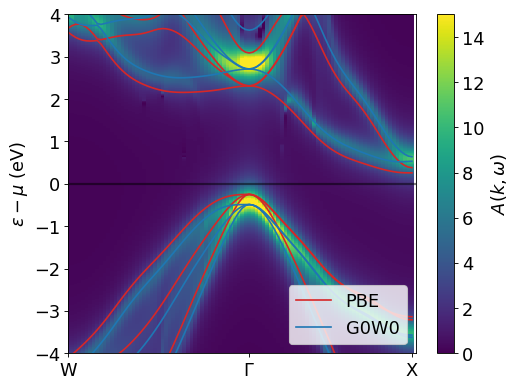

In [11]:
import matplotlib.pyplot as plt
import coqui.post_proc.plot_utils as plot_utils

fig, ax = plt.subplots(1, figsize=(7,5.5), dpi=80)

# Spectral function A(k, ω) from the GW checkpoint
plot_utils.spectral_plot(
    ax,                           # matplotlib axis class 
    f"{coqui_dir}/si.mbpt.h5",    # CoQui checkpoint h5
    calc_type="mbpt",             # read MBPT simulation data
    vmax=15,                      # color scale cap for A(k, ω)
)

plot_utils.band_plot(
    ax, 
    f"data/coqui/si/777/si_qpg0w0.mbpt.h5", 
    iteration=0, 
    color='tab:red', 
    label='PBE'
)

plot_utils.band_plot(
    ax, 
    f"data/coqui/si/777/si_qpg0w0.mbpt.h5", 
    iteration=1, 
    color='tab:blue', 
    label='G0W0'
)

ax.axhline(y=0, color="black", linestyle="-", linewidth=2.0, alpha=0.5)
ax.set_ylim(-4, 4)
ax.legend(loc=4, fontsize=16)